# Package Imports

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

import plotly
plotly.offline.init_notebook_mode(connected=True)

import sys
sys.path.append("..")

In [2]:
import thor

thor.setupOorb()
config = thor.Config()

In [3]:
DATABASE = "../data/msst_survey.db"
con = sql.connect(DATABASE)

## Config

In [4]:
from thor import Config

## Plotting Code

In [5]:
from thor.plotting import plotProjections
from thor.plotting import plotProjections3D
from thor.plotting import plotObservations
from thor.plotting import plotObservations3D
from thor.plotting import plotBinnedContour
from thor.plotting import plotScatterContour
from thor.plotting import plotCell
from thor.plotting import _setPercentage

## Classes 

In [6]:
from thor import Cell
from thor import TestParticle

## Functions

In [7]:
from thor import findAverageObject
from thor import findExposureTimes
from thor import buildCellForVisit
from thor import rangeAndShift
from thor import clusterAndLink
from thor import analyzeClusters
from thor import runRangeAndShiftOnVisit
from thor import runClusterAndLinkOnVisit

# Load Data

In [8]:
observationsNoNoise = pd.read_sql("""SELECT * FROM observations""", con)
noise = pd.read_sql("""SELECT * FROM noise_100""", con)
noise["obsId"] = np.arange(observationsNoNoise["obsId"].values[-1] + 1, observationsNoNoise["obsId"].values[-1] + 1 + len(noise))

In [9]:
observations = pd.concat([observationsNoNoise, noise], sort=False)
observations.reset_index(inplace=True, drop=True)
del observationsNoNoise
del noise

In [10]:
survey = pd.read_sql("""SELECT * FROM survey""", con)

In [11]:
orbits = pd.read_sql("""SELECT * FROM mpcOrbitCat""", con)
# Only grab the orbits of objects with observations
orbits = orbits[orbits["designation"].isin(observations["designation"].unique())]

In [12]:
neos = orbits[orbits["a_au"] <= 1.3]["designation"].values

## Range and Shift

In [13]:
projected_obs, average_obj = runRangeAndShiftOnVisit(observations, 
                        1, 
                        None,
                        None,
                        useAverageObject=True,
                        searchArea=10,
                        cellArea=10)

THOR: runRangeAndShiftOnVisit
-------------------------
Running Thor on visit 1...
Search cell area: 10 
Search cell shape: square 
Cell area: 10 
Cell shape: square 

THOR: findAverageObject
-------------------------
p3143 is the most average object.
-------------------------

THOR: rangeAndShift
-------------------------
Running range and shift...
Assuming r = 2.7617290181 AU
Assuming v = [-0.00964426 -0.00379003  0.00017245] AU per day
Preparing rotation matrices...
Convering to ecliptic coordinates...
Calculating object to observer unit vector...
Calculating object to observer distance assuming r = 2.7617290181 AU...
Calculating object to observer position vector...
Calculating barycentic object position vector...
Calculating vector normal to plane of orbit...
Calculating R1 rotation matrix...
Calculating R2 rotation matrix...
Calculating final rotation matrix...
Done.

THOR: findExposureTimes
-------------------------
Generating particle ephemeris for the middle of every night.
Fi

## Cluster and Link

In [14]:
allClusters, clusterMembers = clusterAndLink(
        projected_obs,
        eps=0.005, 
        minSamples=5, 
        vxRange=[-0.1, 0.1], 
        vyRange=[-0.1, 0.1],
        vxBins=200,
        vyBins=200, 
        threads=5)

THOR: clusterAndLink
-------------------------
Running velocity space clustering...
X velocity range: [-0.1, 0.1]
X velocity bins: 200
Y velocity range: [-0.1, 0.1]
Y velocity bins: 200
User defined x velocity values: False
User defined y velocity values: False
Velocity grid size: 40000
Max sample distance: 0.005
Minimum samples: 5
Using 5 threads...
Done. Completed in 2272.7860679626465 seconds.

Restructuring clusters...
Done. Completed in 3.5029549598693848 seconds.

Found 32179 clusters.
Total time in seconds: 2276.2892920970917
-------------------------



## Analysis

In [15]:
allClusters, clusterMembers, allObjects, summary = analyzeClusters(
    projected_obs,
    allClusters, 
    clusterMembers, 
    minSamples=5, 
    partialThreshold=1.0)

THOR: analyzeClusters
-------------------------
Analyzing observations...
Object observations: 21840
Noise observations: 11822
Observation contamination (%): 35.11971956508823
Unique objects: 3055
Unique objects with at least 5 detections: 1856
Unique objects with at least 100.0% of 5 detections: 1856

Analyzing clusters...
Pure clusters: 5911
Partial clusters: 0
Duplicate visit clusters: 15229
False clusters: 26268
Total clusters: 32179
Cluster contamination (%): 81.63087728021381
Unique linked objects: 1082
Unique missed objects: 774
Completeness (%): 58.297413793103445
Done.
Total time in seconds: 0.3488807678222656
-------------------------



In [16]:
projected_obs.to_csv("project_obs_200x200_visit1.csv", index=False, sep=" ")

In [17]:
visitId = 1
columnMapping = Config.columnMapping
avg_obj = average_obj[columnMapping["name"]].values[0]
o = orbits[orbits[columnMapping["name"]] == avg_obj]
    
found = orbits[orbits[columnMapping["name"]].isin(allObjects[allObjects["found"] == 1][columnMapping["name"]])]
missed = orbits[orbits[columnMapping["name"]].isin((allObjects[(allObjects["found"] == 0) & (allObjects["findable"] == 1)][columnMapping["name"]]))]

Text(2.90677,34.9,'Missed objects: 775')

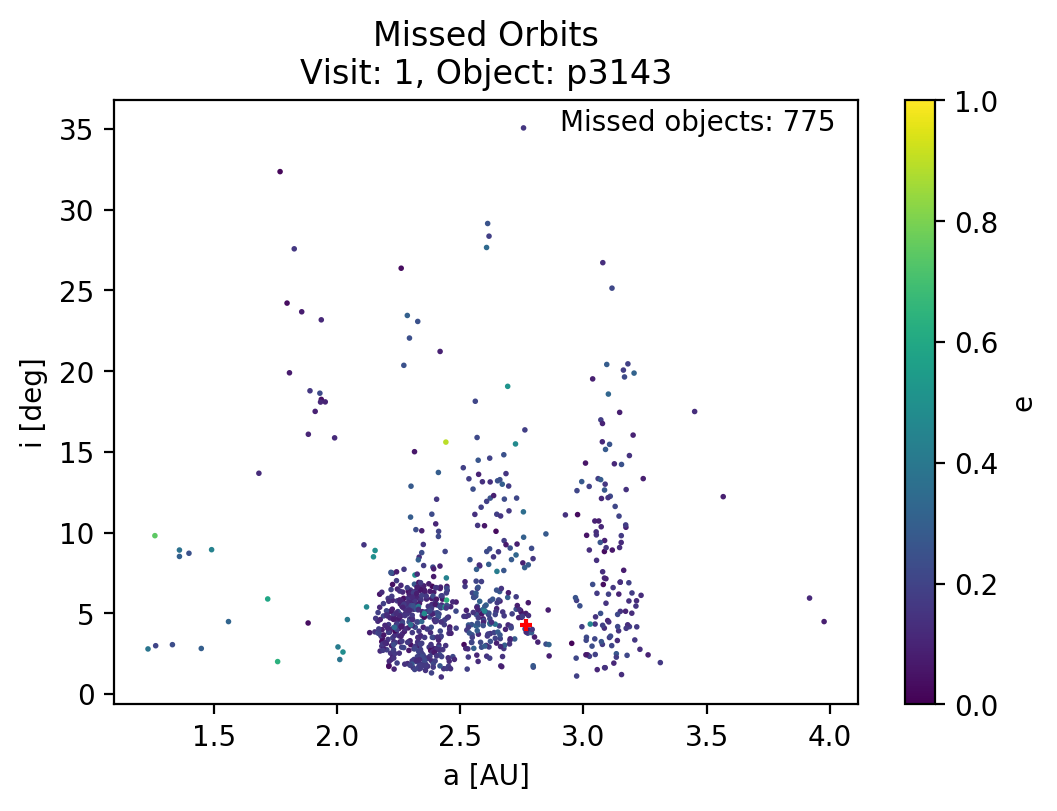

In [43]:
fig, ax = plotScatterContour(missed, 
                             columnMapping["a_au"],
                             columnMapping["i_deg"],
                             columnMapping["e"],
                             plotCounts=False, 
                             logCounts=True, 
                             countLevels=4, 
                             mask=None,
                             xLabel="a [AU]",
                             yLabel="i [deg]",
                             zLabel="e",
                             scatterKwargs={"s": 1, "vmin": 0, "vmax": 1})
ax.scatter(o["a_au"].values, o["i_deg"].values, c="r", s=20, marker="+")
ax.set_title("Missed Orbits\nVisit: {}, Object: {}".format(visitId, avg_obj))
ax.text(_setPercentage(ax.get_xlim(), 0.6), _setPercentage(ax.get_ylim(), 0.95), "Missed objects: {}".format(len(missed)))


Text(3.05748,27.5187,'Missed objects: 1085')

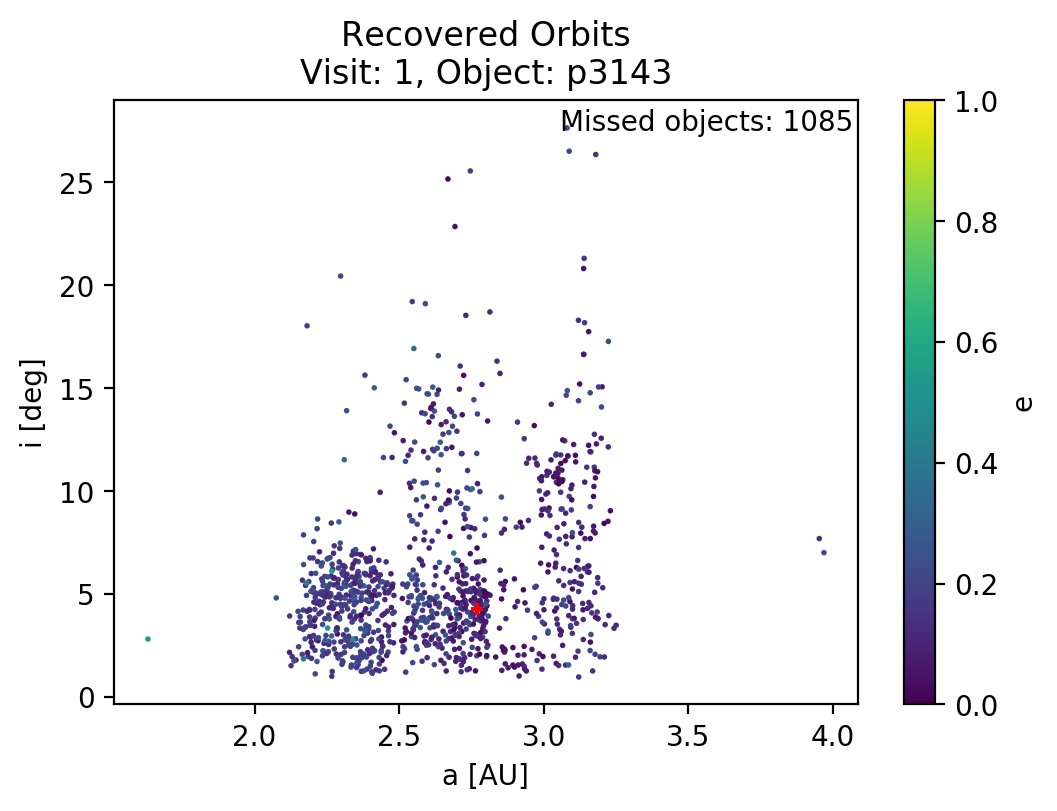

In [42]:
fig, ax = plotScatterContour(found, 
                             columnMapping["a_au"],
                             columnMapping["i_deg"],
                             columnMapping["e"],
                             plotCounts=False, 
                             logCounts=True, 
                             countLevels=4, 
                             mask=None,
                             xLabel="a [AU]",
                             yLabel="i [deg]",
                             zLabel="e",
                             scatterKwargs={"s": 1, "vmin": 0, "vmax": 1})        
ax.scatter(o["a_au"].values, o["i_deg"].values, c="r", s=20, marker="+")
ax.set_title("Recovered Orbits\nVisit: {}, Object: {}".format(visitId, avg_obj))
ax.text(_setPercentage(ax.get_xlim(), 0.6), _setPercentage(ax.get_ylim(), 0.95), "Missed objects: {}".format(len(found)))


In [34]:
found_obs = projected_obs[projected_obs[columnMapping["name"]].isin(allObjects[allObjects["found"] == 1][columnMapping["name"]])]
missed_obs = projected_obs[projected_obs[columnMapping["name"]].isin((allObjects[(allObjects["found"] == 0) & (allObjects["findable"] == 1)][columnMapping["name"]]))]
obs = projected_obs[projected_obs[columnMapping["name"]] == avg_obj]

Text(0.5,1,'All Orbits\nVisit: 1, Object: p3143')

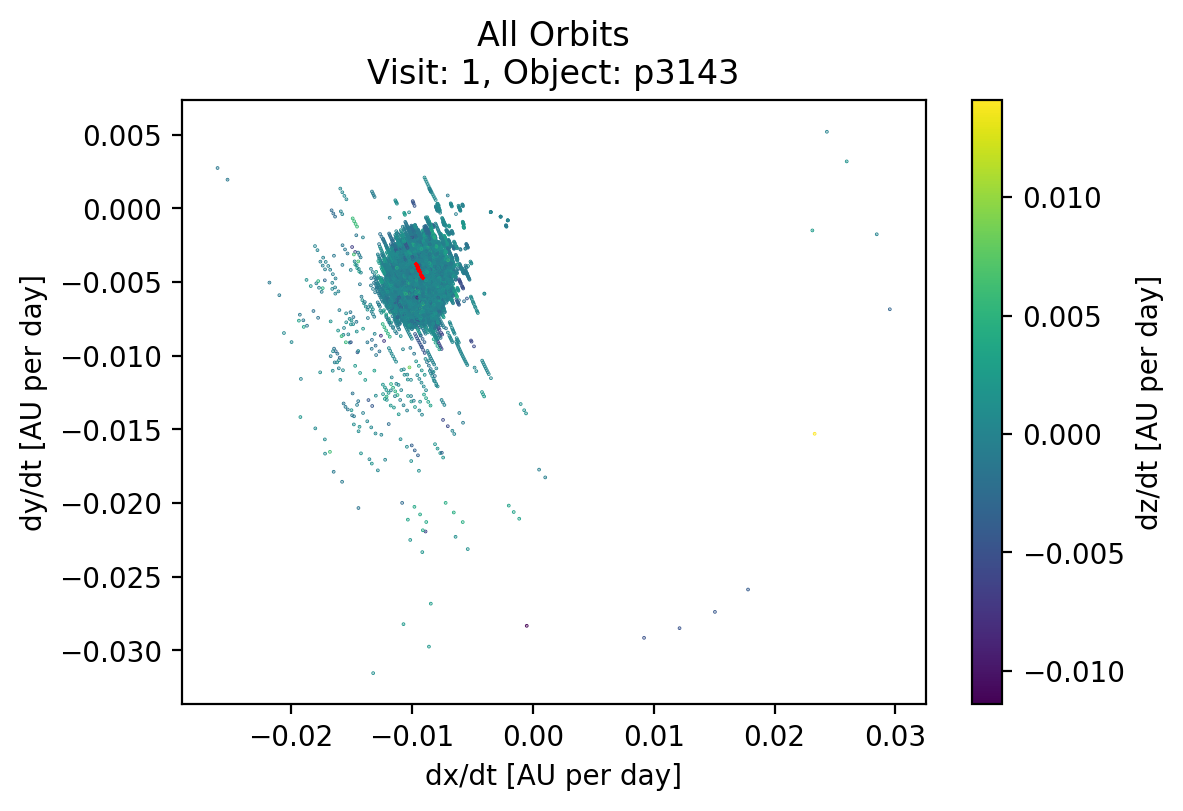

In [50]:
fig, ax = plotScatterContour(projected_obs, 
                                 columnMapping["obj_dx/dt_au_p_day"], 
                                 columnMapping["obj_dy/dt_au_p_day"], 
                                 columnMapping["obj_dz/dt_au_p_day"],
                                 countLevels=4, 
                                 xLabel="dx/dt [AU per day]",
                                 yLabel="dy/dt [AU per day]",
                                 zLabel="dz/dt [AU per day]")
   
#ax.text(_setPercentage(ax.get_xlim(), 0.6), _setPercentage(ax.get_ylim(), 0.95), "Missed objects: {}".format(len(missed)))
ax.scatter(*obs[[columnMapping["obj_dx/dt_au_p_day"], columnMapping["obj_dy/dt_au_p_day"]]].values.T, c="r", s=1, marker="+")
ax.set_title("All Orbits\nVisit: {}, Object: {}".format(visitId, avg_obj))

Text(0.5,1,'Missed Orbits\nVisit: 1, Object: p3143')

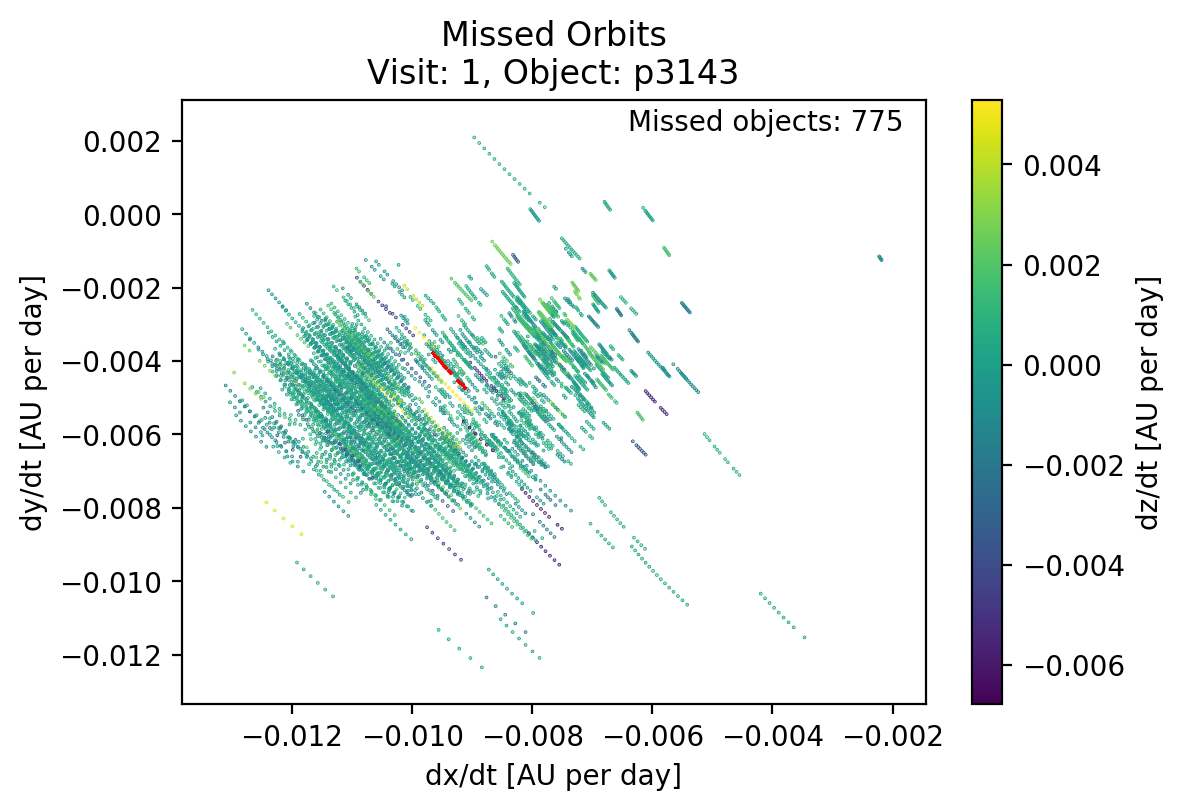

In [38]:
fig, ax = plotScatterContour(missed_obs, 
                                 columnMapping["obj_dx/dt_au_p_day"], 
                                 columnMapping["obj_dy/dt_au_p_day"], 
                                 columnMapping["obj_dz/dt_au_p_day"],
                                 countLevels=4, 
                                 xLabel="dx/dt [AU per day]",
                                 yLabel="dy/dt [AU per day]",
                                 zLabel="dz/dt [AU per day]")
   
ax.text(_setPercentage(ax.get_xlim(), 0.6), _setPercentage(ax.get_ylim(), 0.95), "Missed objects: {}".format(len(missed)))
ax.scatter(*obs[[columnMapping["obj_dx/dt_au_p_day"], columnMapping["obj_dy/dt_au_p_day"]]].values.T, c="r", s=1, marker="+")
ax.set_title("Missed Orbits\nVisit: {}, Object: {}".format(visitId, avg_obj))

Text(-0.00842598,0.000525278,'Found objects: 1085')

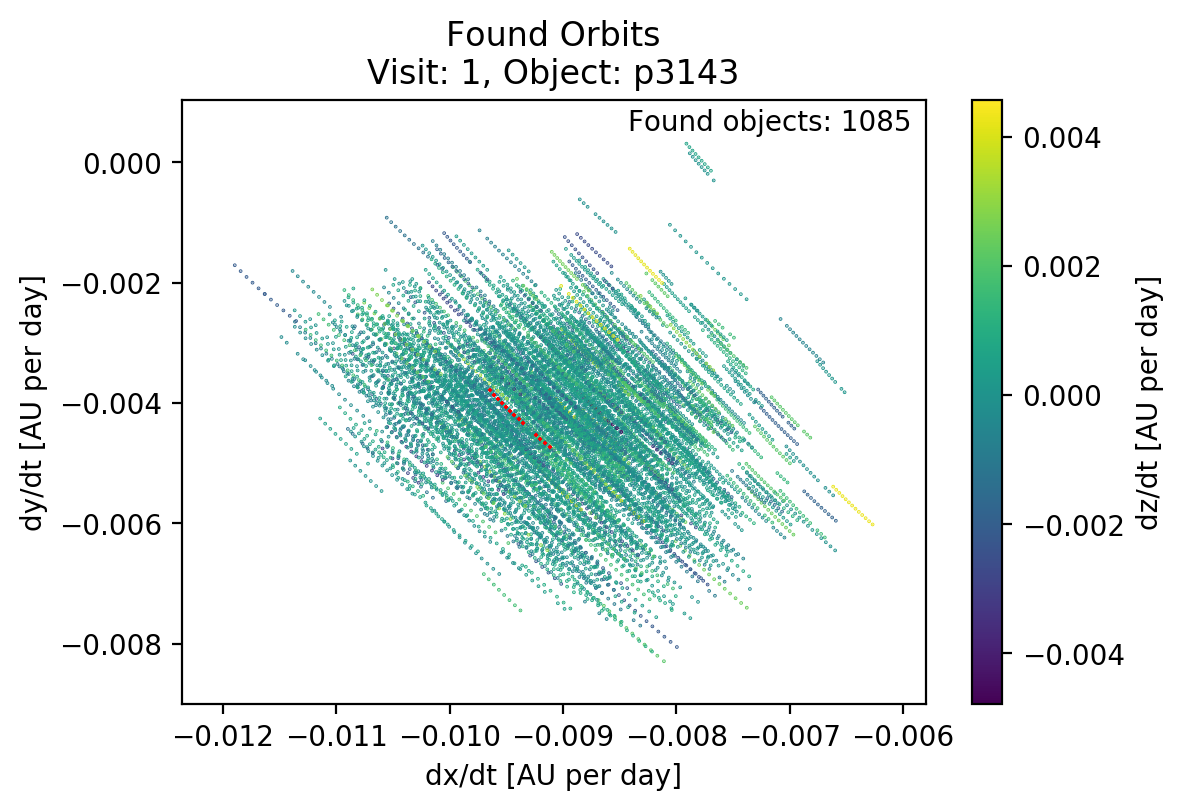

In [40]:
fig, ax = plotScatterContour(found_obs, 
                                 columnMapping["obj_dx/dt_au_p_day"], 
                                 columnMapping["obj_dy/dt_au_p_day"], 
                                 columnMapping["obj_dz/dt_au_p_day"],
                                 countLevels=4, 
                                 xLabel="dx/dt [AU per day]",
                                 yLabel="dy/dt [AU per day]",
                                 zLabel="dz/dt [AU per day]")
   
ax.scatter(*obs[[columnMapping["obj_dx/dt_au_p_day"], columnMapping["obj_dy/dt_au_p_day"]]].values.T, c="r", s=1, marker="+")
ax.set_title("Found Orbits\nVisit: {}, Object: {}".format(visitId, avg_obj))
ax.text(_setPercentage(ax.get_xlim(), 0.6), _setPercentage(ax.get_ylim(), 0.95), "Found objects: {}".format(len(found)))

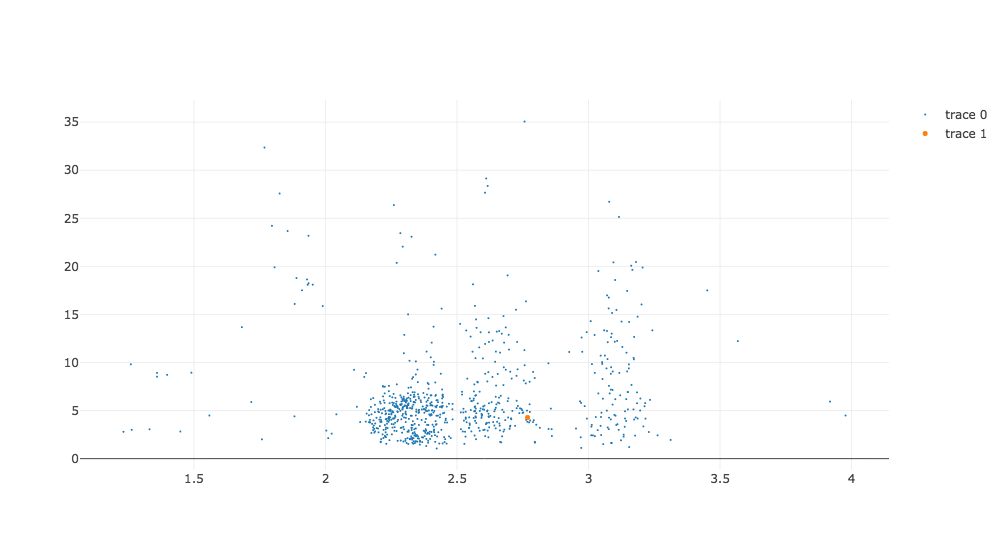

In [21]:
colorByObject = False
dataframe = missed
data = []
if colorByObject is True:
    for name in dataframe[columnMapping["name"]].unique():
        obj = dataframe[dataframe[columnMapping["name"]] == name]
        if name == "NS":
            trace = plotly.graph_objs.Scatter(
                x=obj[columnMapping["RA_deg"]],
                y=obj[columnMapping["Dec_deg"]],
                name=name,
                mode="markers",
                marker=dict(size=2))
        else:
            trace = plotly.graph_objs.Scatter(
                x=obj[columnMapping["RA_deg"]],
                y=obj[columnMapping["Dec_deg"]],
                name=name,
                mode="markers",
                marker=dict(size=2))
        data.append(trace)
else:
    trace = plotly.graph_objs.Scatter(
        x=dataframe[columnMapping["a_au"]],
        y=dataframe[columnMapping["i_deg"]],
        mode="markers",
        text=dataframe[columnMapping["name"]],
        marker=dict(size=2)
    )
    data.append(trace)
    
data.append(plotly.graph_objs.Scatter(
        x=dataframe[dataframe["designation"].isin(["p3143"])][columnMapping["a_au"]],
        y=dataframe[dataframe["designation"].isin(["p3143"])][columnMapping["i_deg"]],
        mode="markers",
        text=dataframe[dataframe["designation"].isin(["p3143"])][columnMapping["name"]],
        marker=dict(size=5)
    ))

layout = dict(
    width=550,
    height=550,
    autosize=False,
    title="",
    scene=dict(
        xaxis=dict(
            title="RA [deg]",
        ),
        yaxis=dict(
            title="Dec [deg]",
        ),
        aspectratio = dict(x=1, y=1)))

fig = plotly.graph_objs.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

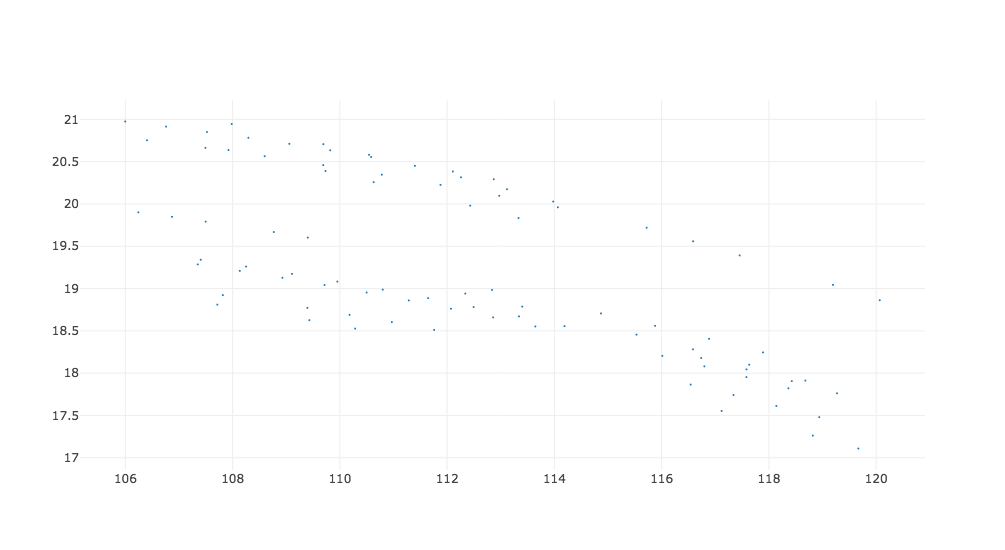

In [22]:
ooi = ["h7943", "d1608", "K13A77A", "U0752", "K07RM5N", "K9320", "p3143", "25204", "i933", "K06QA2V", "p0707", "K18B09U"]
projected_obs_ooi = projected_obs[projected_obs["designation"].isin(ooi)]
fig = plotObservations(projected_obs_ooi)

In [28]:
projected_obs_ooi[projected_obs_ooi["designation"] == "d1608"]

,obsId,visitId,fieldId,fieldRA_deg,fieldDec_deg,exp_mjd,night,designation,code,mjd_utc,...,HEclObsy_X_au,HEclObsy_Y_au,HEclObsy_Z_au,EccAnom,TrueAnom,PosAngle_deg,theta_x_deg,theta_y_deg,theta_x_eq_deg,theta_y_eq_deg
957,958,1,1,106.712809,20.041638,59739.937500,59740,d1608,I11,59739.937500,...,-0.197823,-0.995696,0.000026,5.721371,6.067510,98.179051,1.398496,0.960028,1.210249,87.881420
653029,653030,2440,40,109.875087,20.041638,59743.964583,59744,d1608,I11,59743.964583,...,-0.130615,-1.007156,0.000032,6.631648,7.032608,98.862508,1.544059,0.890406,1.317605,0.511954
980786,980787,3640,40,109.875087,20.041638,59745.964583,59746,d1608,I11,59745.964583,...,-0.096999,-1.011143,0.000034,7.083687,7.511831,99.197961,1.615453,0.855785,1.369257,0.470156
1647324,1647325,6041,41,113.037364,20.041638,59749.965278,59750,d1608,I11,59749.965278,...,-0.029457,-1.015707,0.000035,7.987839,8.470266,99.864497,1.765157,0.786596,1.476121,0.385086
1984125,1984126,7241,41,113.037364,20.041638,59751.965278,59752,d1608,I11,59751.965278,...,0.004387,-1.016276,0.000035,8.439791,8.949303,100.195823,1.843426,0.752046,1.531297,0.341780


In [30]:
observations[observations["designation"] == "d1608"]

,obsId,visitId,fieldId,fieldRA_deg,fieldDec_deg,exp_mjd,night,designation,code,mjd_utc,...,HEclObj_Z_au,HEclObj_dX/dt_au_p_day,HEclObj_dY/dt_au_p_day,HEclObj_dZ/dt_au_p_day,HEclObsy_X_au,HEclObsy_Y_au,HEclObsy_Z_au,EccAnom,TrueAnom,PosAngle_deg
957,958,1,1,106.712809,20.041638,59739.937500,59740,d1608,I11,59739.937500,...,-0.106866,-0.009731,-0.004967,-0.000614,-0.197823,-0.995696,0.000026,5.721371,6.067510,98.179051
328221,328222,1240,40,109.875087,20.041638,59741.964583,59742,d1608,I11,59741.964583,...,-0.108107,-0.009691,-0.005045,-0.000610,-0.164085,-1.002039,0.000030,6.179582,6.553330,98.525477
653029,653030,2440,40,109.875087,20.041638,59743.964583,59744,d1608,I11,59743.964583,...,-0.109324,-0.009650,-0.005121,-0.000607,-0.130615,-1.007156,0.000032,6.631648,7.032608,98.862508
980786,980787,3640,40,109.875087,20.041638,59745.964583,59746,d1608,I11,59745.964583,...,-0.110534,-0.009609,-0.005197,-0.000603,-0.096999,-1.011143,0.000034,7.083687,7.511831,99.197961
1313538,1313539,4841,41,113.037364,20.041638,59747.965278,59748,d1608,I11,59747.965278,...,-0.111736,-0.009567,-0.005273,-0.000599,-0.063261,-1.013996,0.000035,7.535856,7.991163,99.531919
1647324,1647325,6041,41,113.037364,20.041638,59749.965278,59750,d1608,I11,59749.965278,...,-0.112932,-0.009525,-0.005348,-0.000596,-0.029457,-1.015707,0.000035,7.987839,8.470266,99.864497
1984125,1984126,7241,41,113.037364,20.041638,59751.965278,59752,d1608,I11,59751.965278,...,-0.114119,-0.009482,-0.005423,-0.000592,0.004387,-1.016276,0.000035,8.439791,8.949303,100.195823
2324188,2324189,8441,41,113.037364,20.041638,59753.965278,59754,d1608,I11,59753.965278,...,-0.115299,-0.009438,-0.005497,-0.000588,0.038231,-1.015697,0.000034,8.891711,9.428272,100.525868
2673987,2673988,9680,80,116.199642,20.041638,59755.992361,59756,d1608,I11,59755.992361,...,-0.116487,-0.009393,-0.005572,-0.000584,0.072497,-1.013944,0.000036,9.349715,9.913652,100.847773
3020345,3020346,10880,80,116.199642,20.041638,59757.992361,59758,d1608,I11,59757.992361,...,-0.117652,-0.009348,-0.005646,-0.000580,0.106225,-1.011053,0.000035,9.801563,10.392470,101.173824


In [51]:
observations[observations["designation"] == "p3143"]

,obsId,visitId,fieldId,fieldRA_deg,fieldDec_deg,exp_mjd,night,designation,code,mjd_utc,...,HEclObj_Z_au,HEclObj_dX/dt_au_p_day,HEclObj_dY/dt_au_p_day,HEclObj_dZ/dt_au_p_day,HEclObsy_X_au,HEclObsy_Y_au,HEclObsy_Z_au,EccAnom,TrueAnom,PosAngle_deg
1227,1228,1,1,106.712809,20.041638,59739.937500,59740,p3143,I11,59739.937500,...,-0.196432,-0.009644,-0.003790,0.000172,-0.197823,-0.995696,0.000026,88.331046,93.071041,95.762174
323125,323126,1201,1,106.712809,20.041638,59741.937500,59742,p3143,I11,59741.937500,...,-0.196082,-0.009610,-0.003859,0.000178,-0.164536,-1.001956,0.000028,88.759892,93.499320,96.113776
653301,653302,2440,40,109.875087,20.041638,59743.964583,59744,p3143,I11,59743.964583,...,-0.195715,-0.009574,-0.003929,0.000184,-0.130615,-1.007156,0.000032,89.194274,93.932858,96.470781
981067,981068,3640,40,109.875087,20.041638,59745.964583,59746,p3143,I11,59745.964583,...,-0.195343,-0.009539,-0.003998,0.000189,-0.096999,-1.011143,0.000034,89.622586,94.360072,96.816060
1311852,1311853,4840,40,109.875087,20.041638,59747.964583,59748,p3143,I11,59747.964583,...,-0.194959,-0.009503,-0.004066,0.000194,-0.063272,-1.013995,0.000035,90.050634,94.786758,97.158997
1647633,1647634,6041,41,113.037364,20.041638,59749.965278,59750,p3143,I11,59749.965278,...,-0.194565,-0.009467,-0.004134,0.000200,-0.029457,-1.015707,0.000035,90.478566,95.213066,97.499866
1984420,1984421,7241,41,113.037364,20.041638,59751.965278,59752,p3143,I11,59751.965278,...,-0.194160,-0.009430,-0.004201,0.000205,0.004387,-1.016276,0.000035,90.906086,95.638702,97.838645
2324486,2324487,8441,41,113.037364,20.041638,59753.965278,59754,p3143,I11,59753.965278,...,-0.193744,-0.009392,-0.004268,0.000211,0.038231,-1.015697,0.000034,91.333344,96.063815,98.175374
2667730,2667731,9641,41,113.037364,20.041638,59755.965278,59756,p3143,I11,59755.965278,...,-0.193317,-0.009355,-0.004335,0.000216,0.072038,-1.013969,0.000033,91.760339,96.488405,98.509935
3018705,3018706,10879,79,116.199642,16.879360,59757.991667,59758,p3143,I11,59757.991667,...,-0.192874,-0.009316,-0.004402,0.000221,0.106213,-1.011054,0.000035,92.192701,96.918067,98.837177


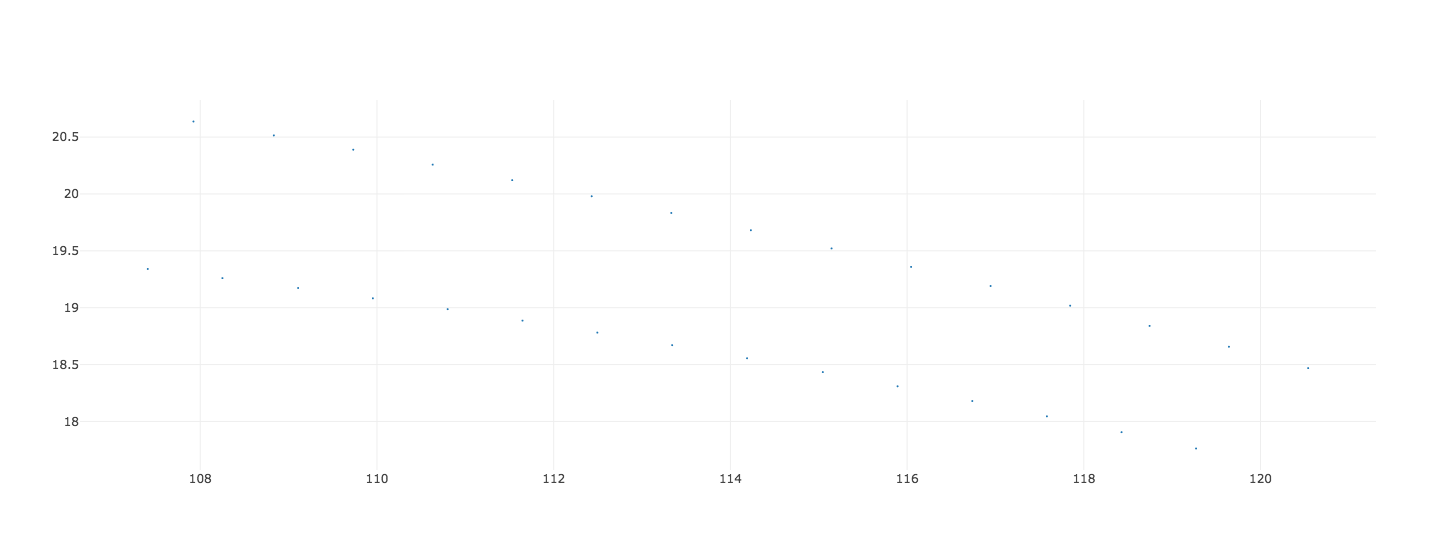

In [53]:
fig = plotObservations(observations[observations["designation"].isin(["p3143", "d1608"])])

In [63]:
findExposureTimes?

Signature: findExposureTimes(observations, r, v, mjdStart, nights, vMax=3.0, verbose=True, columnMapping={'obs_id': 'obsId', 'exp_mjd': 'exp_mjd', 'visit_id': 'visitId', 'field_id': 'fieldId', 'field_RA_deg': 'fieldRA_deg', 'field_Dec_deg': 'fieldDec_deg', 'night': 'night', 'RA_deg': 'RA_deg', 'Dec_deg': 'Dec_deg', 'obs_x_au': 'HEclObsy_X_au', 'obs_y_au': 'HEclObsy_Y_au', 'obs_z_au': 'HEclObsy_Z_au', 'mag': 'VMag', 'name': 'designation', 'Delta_au': 'Delta_au', 'r_au': 'r_au', 'obj_x_au': 'HEclObj_X_au', 'obj_y_au': 'HEclObj_Y_au', 'obj_z_au': 'HEclObj_Z_au', 'obj_dx/dt_au_p_day': 'HEclObj_dX/dt_au_p_day', 'obj_dy/dt_au_p_day': 'HEclObj_dY/dt_au_p_day', 'obj_dz/dt_au_p_day': 'HEclObj_dZ/dt_au_p_day', 'a_au': 'a_au', 'i_deg': 'i_deg', 'e': 'e'})
Docstring:
Finds the unique exposure times of all detections that fall within
a maximum search radius (set by a maximum angular velocity) for a 
test particle defined by r and v at mjdStart. 

Parameters
----------
observations : `~pandas.DataFr

In [85]:
times = findExposureTimes(observations, 
                  projected_obs[projected_obs["designation"] == "p3143"][Config.x_a].values[0],
                  projected_obs[projected_obs["designation"] == "p3143"][Config.v].values[0],
                  projected_obs["exp_mjd"].min(),
                  observations["night"].unique()[1:],
                  vMax=30)

THOR: findExposureTimes
-------------------------
Generating particle ephemeris for the middle of every night.
Finding optimal exposure times (maximum angular velocity: 30)...

Night: 59741 (1/29)
Propagating particle to 59741.14548611111...
Looking for observations...
Found 0 observations within search area.

Night: 59742 (2/29)
Propagating particle to 59742.14548611111...
Looking for observations...
Found 14752 observations within search area.

Night: 59743 (3/29)
Propagating particle to 59743.14548611111...
Looking for observations...
Found 0 observations within search area.

Night: 59744 (4/29)
Propagating particle to 59744.14548611111...
Looking for observations...
Found 15989 observations within search area.

Night: 59745 (5/29)
Propagating particle to 59745.14548611111...
Looking for observations...
Found 0 observations within search area.

Night: 59746 (6/29)
Propagating particle to 59746.14548611111...
Looking for observations...
Found 16303 observations within search area.

N

In [86]:
visits = observations[observations["exp_mjd"].isin(times)]["visitId"].unique()

In [87]:
visits_to = observations[observations["designation"] == "p3143"]["visitId"].unique()
visits_ooi = observations[observations["designation"].isin(ooi)]["visitId"].unique()

In [88]:
np.in1d(visits_to, visits)

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [89]:
visits_ooi[np.where(np.in1d(visits_ooi, visits) == False)]

array([1])

In [84]:
observations[observations["visitId"] == 15641]

,obsId,visitId,fieldId,fieldRA_deg,fieldDec_deg,exp_mjd,night,designation,code,mjd_utc,...,HEclObj_Z_au,HEclObj_dX/dt_au_p_day,HEclObj_dY/dt_au_p_day,HEclObj_dZ/dt_au_p_day,HEclObsy_X_au,HEclObsy_Y_au,HEclObsy_Z_au,EccAnom,TrueAnom,PosAngle_deg
4431065,4431066,15641,41,113.037364,20.041638,59765.965278,59766,00308,I11,59765.965278,...,-0.198052,-0.008950,-0.004371,0.000313,0.239096,-0.988206,0.000032,179.195214,179.227095,98.645473
4431066,4431067,15641,41,113.037364,20.041638,59765.965278,59766,00514,I11,59765.965278,...,-0.090753,-0.009058,-0.003726,-0.000608,0.239096,-0.988206,0.000032,96.127506,98.454811,100.464907
4431067,4431068,15641,41,113.037364,20.041638,59765.965278,59766,00871,I11,59765.965278,...,-0.113617,-0.009487,-0.006016,0.000679,0.239096,-0.988206,0.000032,257.967121,251.320564,97.854341
4431068,4431069,15641,41,113.037364,20.041638,59765.965278,59766,00873,I11,59765.965278,...,-0.154761,-0.008141,-0.004764,0.000756,0.239096,-0.988206,0.000032,219.899295,214.697584,97.538592
4431069,4431070,15641,41,113.037364,20.041638,59765.965278,59766,01189,I11,59765.965278,...,-0.169258,-0.009272,-0.003059,-0.001655,0.239096,-0.988206,0.000032,97.354836,103.879094,102.406636
4431070,4431071,15641,41,113.037364,20.041638,59765.965278,59766,02094,I11,59765.965278,...,-0.042707,-0.010538,-0.006042,-0.001017,0.239096,-0.988206,0.000032,306.366134,301.784631,101.143431
4431071,4431072,15641,41,113.037364,20.041638,59765.965278,59766,02256,I11,59765.965278,...,-0.000672,-0.007665,-0.003102,0.000067,0.239096,-0.988206,0.000032,163.042070,165.748464,99.460160
4431072,4431073,15641,41,113.037364,20.041638,59765.965278,59766,02306,I11,59765.965278,...,-0.175595,-0.009328,-0.003519,-0.000435,0.239096,-0.988206,0.000032,130.787588,133.533473,99.478416
4431073,4431074,15641,41,113.037364,20.041638,59765.965278,59766,02567,I11,59765.965278,...,-0.220690,-0.008866,-0.002915,0.001208,0.239096,-0.988206,0.000032,134.595823,140.135719,96.137417
4431074,4431075,15641,41,113.037364,20.041638,59765.965278,59766,02854,I11,59765.965278,...,-0.015965,-0.009623,-0.006374,-0.001143,0.239096,-0.988206,0.000032,270.650534,263.653302,101.868134


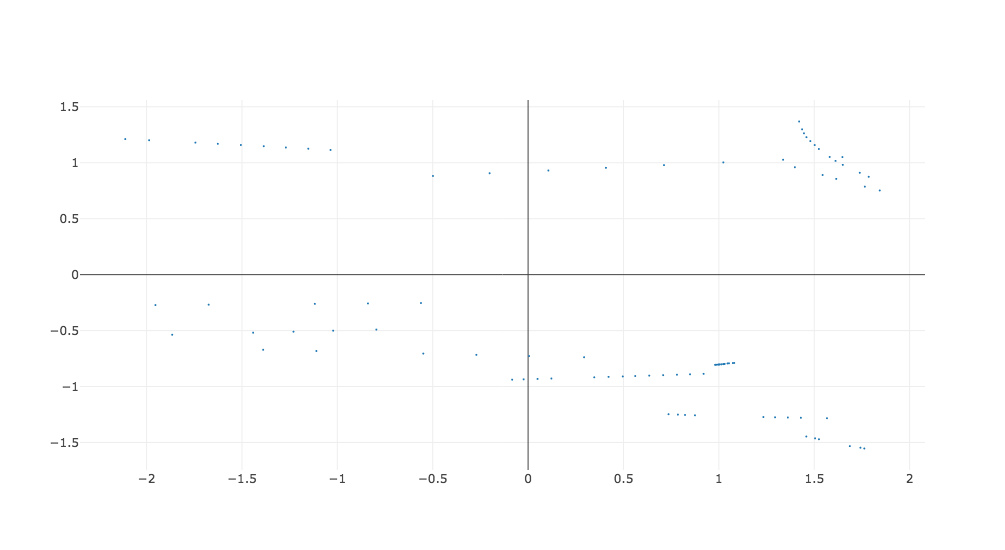

In [31]:
fig = plotProjections(projected_obs_ooi)

In [47]:
allClusters_ooi, clusterMembers_ooi = clusterAndLink(
        projected_obs_ooi,
        eps=0.005, 
        minSamples=5, 
        vxRange=[-1, 1], 
        vyRange=[-1, 1],
        vxBins=1000,
        vyBins=1000, 
        threads=5)

THOR: clusterAndLink
-------------------------
Running velocity space clustering...
X velocity range: [-1, 1]
X velocity bins: 1000
Y velocity range: [-1, 1]
Y velocity bins: 1000
User defined x velocity values: False
User defined y velocity values: False
Velocity grid size: 1000000
Max sample distance: 0.005
Minimum samples: 5
Using 5 threads...
Done. Completed in 217.53368186950684 seconds.

Restructuring clusters...
Done. Completed in 0.27814817428588867 seconds.

Found 6 clusters.
Total time in seconds: 217.81265306472778
-------------------------



In [48]:
allClusters_ooi, clusterMembers_ooi, allObjects_ooi, summary_ooi = analyzeClusters(
    projected_obs_ooi,
    allClusters_ooi, 
    clusterMembers_ooi, 
    minSamples=5, 
    partialThreshold=1.0)

THOR: analyzeClusters
-------------------------
Analyzing observations...
Object observations: 91
Noise observations: 0
Observation contamination (%): 0.0
Unique objects: 11
Unique objects with at least 5 detections: 11
Unique objects with at least 100.0% of 5 detections: 11

Analyzing clusters...
Pure clusters: 6
Partial clusters: 0
Duplicate visit clusters: 0
False clusters: 0
Total clusters: 6
Cluster contamination (%): 0.0
Unique linked objects: 5
Unique missed objects: 6
Completeness (%): 45.45454545454545
Done.
Total time in seconds: 0.07193398475646973
-------------------------



## Additional Plots

In [ ]:
fig = plotProjections(
    projected_obs[projected_obs["designation"].isin(allObjects[allObjects["found"] == 1]["designation"].values)],
    colorByObject=False)

In [ ]:
fig = plotProjections(
    projected_obs[projected_obs["designation"].isin(allObjects[(allObjects["findable"] == 1) & (allObjects["found"] == 0)]["designation"].values)],
    colorByObject=False)

In [ ]:
fig = plotProjections(
    projected_obs[projected_obs["designation"].isin(allObjects[(allObjects["findable"] == 1) & (allObjects["found"] == 0)]["designation"].values)],
    colorByObject=True)

In [ ]:
fig = plotProjections(
    projected_obs[projected_obs["obsId"].isin(clusterMembers[clusterMembers["cluster_id"].isin(allClusters[allClusters["pure"] == 1]["cluster_id"].values)]["obs_id"])],
    colorByObject=False)

In [ ]:
fig = plotProjections3D(
    projected_obs[projected_obs["obsId"].isin(clusterMembers[clusterMembers["cluster_id"].isin(allClusters[allClusters["pure"] == 1]["cluster_id"].values)]["obs_id"])],
    colorByObject=False)

In [ ]:
fig = plotProjections3D(
    projected_obs[projected_obs["obsId"].isin(clusterMembers[clusterMembers["cluster_id"].isin([allClusters[allClusters["num_visits"] != allClusters["num_obs"]]["cluster_id"].values[0]])]["obs_id"])],
    colorByObject=False)

In [ ]:
fig = plotProjections3D(
    projected_obs[projected_obs["obsId"].isin(clusterMembers[clusterMembers["cluster_id"].isin(allClusters[allClusters["pure"] == 1]["cluster_id"].values)]["obs_id"])],
    colorByObject=False)